Andrew Welling

# Testing all RAID implementations

In [1]:
import raid4
%load_ext autoreload
%autoreload 2

import raid, raid0, raid1, raid10, raid3, raid4, raid5, raid6

In [2]:
test_data = [[1,2],[1,2,3,4],[5,6],[7,8],[9,10],[11,12],[13,14]]
r0 = raid0.RAID0(2,7)
r1 = raid1.RAID1(2,7)
r10 = raid10.RAID10(4,7)
r3 = raid3.RAID3(5,16) # blocks = len of above array flat
r4 = raid4.RAID4(4,7) # 3 data, 1 parity drive
r5 = raid5.RAID5(4,7) # 4 data drives with p blocks
r6 = raid6.RAID6(5,7) # 4 data 2 q,p

# raid 3 only supports 4 bit numbers currently
raids = [r0,r1,r10,r3,r4,r5,r6]

# fill r0,r1,r10 drives
for i,d in enumerate(test_data):
    for r in range(3): #r0,r1,r10
        raids[r].write(i,d)
print(raids[0].__str__())
print(raids[1].__str__())
print(raids[2].__str__())

# fill raid3+ (note a flattened data list must be used instead)
flat = [item for sublist in test_data for item in sublist]
for i,d in enumerate(flat):
    raids[3].write(i,d)

print(raids[3].__str__())

print("RAID3 values across each drive/at block:")
print(raids[3].get_values()) # last drive is p
print('\n')

# fill r4,5,6
test_data = [[1,2,3],[3,4,5],[5,6,7],[7,8,9],[9,10,11],[11,12,13],[13,14,15]]
for i,d in enumerate(test_data):
    for r in range(4,7):
        raids[r].write(i,d)

print(raids[4].__str__()) # last drive is p
print(raids[5].__str__())
print(raids[6].__str__()) # last drive is q, second to last is p



RAID0 status:
drive 0 [alive]: [[1], [1, 2], [5], [7], [9], [11], [13]]
drive 1 [alive]: [[2], [3, 4], [6], [8], [10], [12], [14]]


RAID1 status:
drive 0 [alive]: [[1, 2], [1, 2, 3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13, 14]]
drive 1 [alive]: [[1, 2], [1, 2, 3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13, 14]]


RAID10 status:
drive 0 [alive]: [[1], [1, 2], [5], [7], [9], [11], [13]]
drive 1 [alive]: [[1], [1, 2], [5], [7], [9], [11], [13]]
drive 2 [alive]: [[2], [3, 4], [6], [8], [10], [12], [14]]
drive 3 [alive]: [[2], [3, 4], [6], [8], [10], [12], [14]]


RAID3 status:
drive 0 [alive]: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
drive 1 [alive]: [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1]
drive 2 [alive]: [0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1]
drive 3 [alive]: [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
drive 4 [alive]: [1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1]


RAID3 values across each drive/at block:
[1, 2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1

In [3]:
# simulate a failure on all drives
for i,r in enumerate(raids):
    r.fail_drive(1)
    print(r.__str__())

RAID0 status:
drive 0 [alive]: [[1], [1, 2], [5], [7], [9], [11], [13]]
drive 1 [fail]: [0, 0, 0, 0, 0, 0, 0]


RAID1 status:
drive 0 [alive]: [[1, 2], [1, 2, 3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13, 14]]
drive 1 [fail]: [0, 0, 0, 0, 0, 0, 0]


RAID10 status:
drive 0 [alive]: [[1], [1, 2], [5], [7], [9], [11], [13]]
drive 1 [fail]: [0, 0, 0, 0, 0, 0, 0]
drive 2 [alive]: [[2], [3, 4], [6], [8], [10], [12], [14]]
drive 3 [alive]: [[2], [3, 4], [6], [8], [10], [12], [14]]


RAID3 status:
drive 0 [alive]: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
drive 1 [fail]: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
drive 2 [alive]: [0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1]
drive 3 [alive]: [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
drive 4 [alive]: [1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1]


RAID4 status:
drive 0 [alive]: [1, 3, 5, 7, 9, 11, 13]
drive 1 [fail]: [0, 0, 0, 0, 0, 0, 0]
drive 2 [alive]: [3, 5, 7, 9, 11, 13, 15]
drive 3 [alive]: [0, 2, 4, 6, 8, 10, 1

In [4]:
# attempt recovery
print("simulating recovery")
for i,r in enumerate(raids):
    r.rebuild(1)
    print(r.__str__())


simulating recovery
RAID0 status:
drive 0 [alive]: [[1], [1, 2], [5], [7], [9], [11], [13]]
drive 1 [fail]: [0, 0, 0, 0, 0, 0, 0]


RAID1 status:
drive 0 [alive]: [[1, 2], [1, 2, 3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13, 14]]
drive 1 [alive]: [[1, 2], [1, 2, 3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13, 14]]


RAID10 status:
drive 0 [alive]: [[1], [1, 2], [5], [7], [9], [11], [13]]
drive 1 [alive]: [[1], [1, 2], [5], [7], [9], [11], [13]]
drive 2 [alive]: [[2], [3, 4], [6], [8], [10], [12], [14]]
drive 3 [alive]: [[2], [3, 4], [6], [8], [10], [12], [14]]


RAID3 status:
drive 0 [alive]: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
drive 1 [alive]: [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1]
drive 2 [alive]: [0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1]
drive 3 [alive]: [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
drive 4 [alive]: [1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1]


RAID4 status:
drive 0 [alive]: [1, 3, 5, 7, 9, 11, 13]
drive 1 [alive]: [2, 4, 6, 8, 

# Testing drive rebuildability
Below is a test to check how many failures each system could tolerate

In [5]:
def create_all_drives(data_drives,blocks,data, prob=0.0):
    r0 = raid0.RAID0(data_drives,blocks,prob=prob)
    r1 = raid1.RAID1(data_drives,blocks,prob=prob)
    r10 = raid10.RAID10(data_drives,blocks,prob=prob)
    r3 = raid3.RAID3(data_drives+1,blocks*len(flatten(data)),prob=prob) # 1 parity, blocks = all items in data array flat
    r4 = raid4.RAID4(data_drives+1,blocks,prob=prob) # 1 parity drive
    r5 = raid5.RAID5(data_drives,blocks,prob=prob) # p blocks
    r6 = raid6.RAID6(data_drives+2,blocks,prob=prob) # q,p parity drives
    return [r0,r1,r10,r3,r4,r5,r6]

# used for r3, it needs a 1d array list rather than 2
def flatten(data):
    return [item for sublist in data for item in sublist]

def test_failures(raid_system,max_failures):
    pre_destruct = raid_system.__str__()
    for num_failed in range(1, max_failures + 1):
        # fail some drives
        for i in range(num_failed):
            raid_system.fail_drive(i)
        # rebuild them
        try:
            for i in range(num_failed):
                if raid_system.name == "RAID6" and num_failed >= 2:
                    # raid 6 uses systems of eqs to solve for multiple drives
                    raid_system.rebuild_multiple_drives(list(range(num_failed)))
                else:
                    raid_system.rebuild(i)
                    if raid_system.__str__() != pre_destruct: # rebuild failed on different output than original
                        return num_failed - 1
        except Exception as e: # rebuild failed on error
            return num_failed - 1

    return max_failures

# create new drives
test_data = [[0,1,2,3],[4,5,6,7],[8,9,10,11],[12,13,14,15]]
raids = create_all_drives(4,4,test_data)
# fill raid 3 (it must have a flat array)
flat = flatten(test_data)
for i,d in enumerate(flat):
    raids[3].write(i,d)

# fill rest of raids
for i,d in enumerate(test_data):
    for r in range(7):
        if r != 3: # raid 3 already filled
            raids[r].write(i,d)


fails = []
for r in raids:
    drive_failures = test_failures(r,2)
    print(f"{r.name} tolerated {drive_failures} faiures")
    fails.append(drive_failures)

RAID0 tolerated 0 faiures
RAID1 tolerated 1 faiures
RAID10 tolerated 1 faiures
RAID3 tolerated 1 faiures
RAID4 tolerated 1 faiures
RAID5 tolerated 1 faiures
RAID6 tolerated 2 faiures


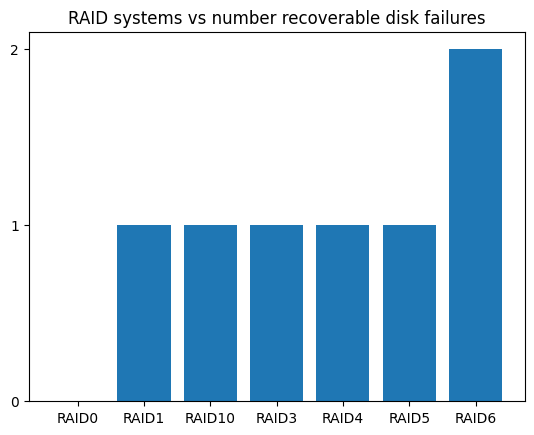

In [6]:
import matplotlib.pyplot as plt

plt.bar([r.name for r in raids], fails)
plt.title('RAID systems vs number recoverable disk failures')
plt.yticks([0, 1, 2])
plt.show()

# Simulating Each RAID System
Each raid system now has a probability of failure during read or write operations, we will keep track of these with counters built into the drives.

In [7]:
import random

def simulation():
    # create random 2d long list of data (1000) to input, must stay at up to 4 bit numbers for raid3
    # add data until failures occur on writes according to raid system probabilitys
    data = [[random.randint(0, 15), random.randint(0, 15),random.randint(0, 15),random.randint(0, 15)] for _ in range(1000)]
    raids = create_all_drives(4,1000,data,prob=.005)

    survival = [0 for r in raids] # track where each system got to in data
    for i,d in enumerate(data):
        for r_num,r in enumerate(raids):
             # raid 3 will go last do to its unique use of bits
            if r_num != 3 and not r.failed: # check for entire system failure and raid 3
                try:
                    # write drives n times
                    r.write(i,d)
                except IOError:
                    # use fail tolerance found earlier to check rebuildability
                    if r.get_failures() > fails[r_num]:
                        print(f"{r.name} has had more drive failures than it can tolerate")
                        survival[r_num] = i
                        r.failed = True
                    else:
                        if r.name == "RAID6" and r.get_failures() >= 2:
                            # raid 6 uses systems of eqs to solve for multiple drives
                            r.rebuild_multiple_drives(list(range(r.get_failures())))
                        else:
                            r.rebuild(r.failed_drives()[0])
    # for raid 3
    for i,d in enumerate(flatten(data)):
        if not raids[3].failed: # check for entire system failure
            try:
                # write drives n times
                raids[3].write(i,d)
            except IOError as e:
                # use fail tolerance found earlier to check rebuildability
                if raids[3].get_failures() > fails[3]:
                    print(f"{raids[3].name} has had more drive failures than it can tolerate")
                    survival[3] = i
                    raids[3].failed = True
                else:
                    raids[3].rebuild(raids[3].failed_drives()[0])

    # get write and failure data across drives
    total_writes = [r.get_writes() for r in raids]
    total_failures = [r.get_writes() for r in raids]

    return survival,total_writes,total_failures

RAID5 has had more drive failures than it can tolerate
RAID6 has had more drive failures than it can tolerate
RAID0 has had more drive failures than it can tolerate
RAID4 has had more drive failures than it can tolerate
RAID10 has had more drive failures than it can tolerate
RAID1 has had more drive failures than it can tolerate
RAID3 has had more drive failures than it can tolerate
RAID0 has had more drive failures than it can tolerate
RAID5 has had more drive failures than it can tolerate
RAID6 has had more drive failures than it can tolerate
RAID10 has had more drive failures than it can tolerate
RAID4 has had more drive failures than it can tolerate
RAID1 has had more drive failures than it can tolerate
RAID3 has had more drive failures than it can tolerate
RAID6 has had more drive failures than it can tolerate
RAID4 has had more drive failures than it can tolerate
RAID10 has had more drive failures than it can tolerate
RAID5 has had more drive failures than it can tolerate
RAID0 h

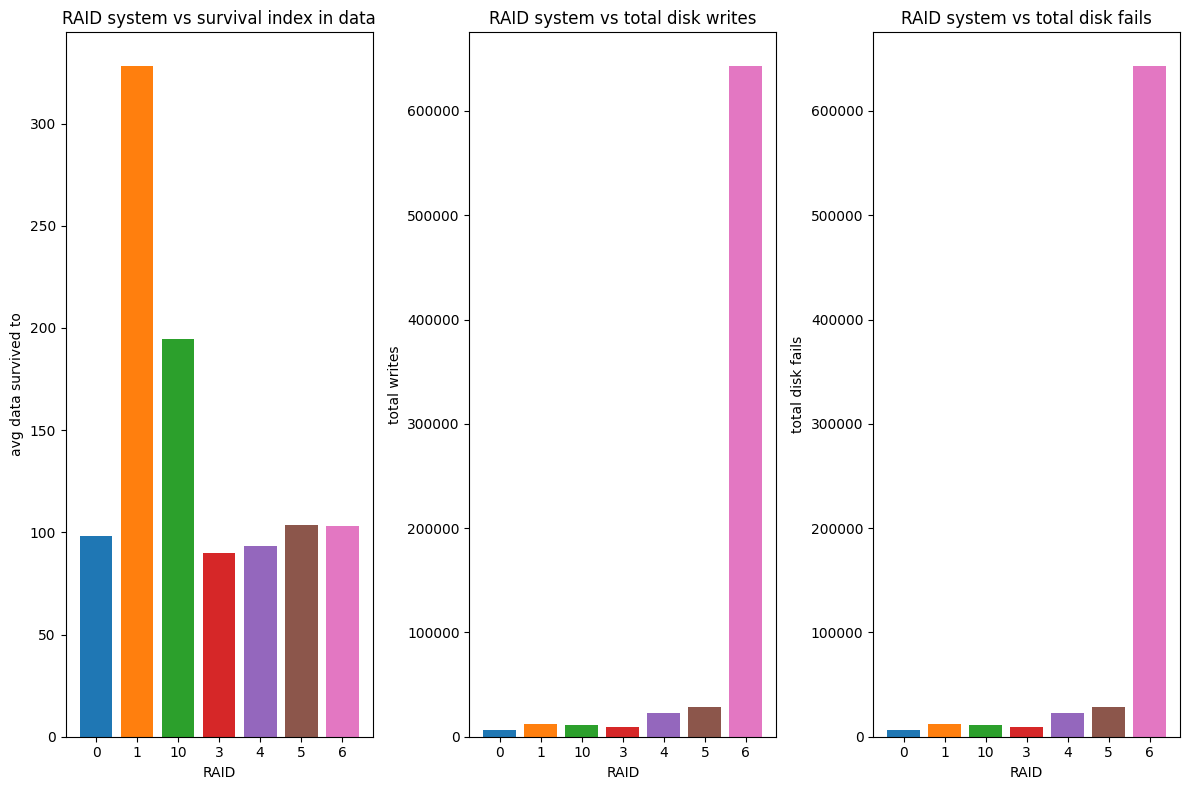

In [8]:
# visualize failures and writes from drives
all_surv = []
all_writes = []
all_fails = []
for n in range(20): # run a simulation 20 times
    survival,writes,failures = simulation()
    all_surv.append(survival)
    all_writes.append(writes)
    all_fails.append(failures)

surv_by_system = [[row[i] for row in all_surv] for i in range(7)]
writes_by_system = [[row[i] for row in all_writes] for i in range(7)]
fails_by_system = [[row[i] for row in all_fails] for i in range(7)]

# modify below to plot by system
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(12,8))

# plot for survival index
for i, surv in enumerate(surv_by_system):
    ax[0].bar(f'{raids[i].name[4:]}', sum(surv) / len(surv))
ax[0].set_title('RAID system vs survival index in data')
ax[0].set_xlabel('RAID')
ax[0].set_ylabel('avg data survived to')

# plot for total writes by system
for i, writes in enumerate(writes_by_system):
    ax[1].bar(f'{raids[i].name[4:]}', sum(writes))
ax[1].set_title('RAID system vs total disk writes')
ax[1].set_xlabel('RAID')
ax[1].set_ylabel('total writes')

# plot for disk fails
for i, fails in enumerate(fails_by_system):
    ax[2].bar(f'{raids[i].name[4:]}', sum(fails))
ax[2].set_title('RAID system vs total disk fails')
ax[2].set_xlabel('RAID')
ax[2].set_ylabel('total disk fails')

plt.tight_layout()
plt.show()